In [9]:
from pathlib import Path
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import argparse

In [10]:
models = list(Path(".").glob("cifar_edgenet_cost_1_*"))
c1 = [float(i.stem.split("_")[-4]) for i in models]
ce = [float(i.stem.split("_")[-1]) for i in models]

In [11]:
# dataset pre-prossessing
Batch_size=16
Batch_size_test=16
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")
print(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load train and test set
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset_full = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset_full, batch_size=Batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset_full, batch_size=Batch_size_test, shuffle=False, num_workers=2)

cuda
Files already downloaded and verified
Files already downloaded and verified


In [12]:
class LocalNet(nn.Module):
    def __init__(self):
        super(LocalNet, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.fc2 = nn.Linear(3 * 32 * 32, len(trainset_full.classes))

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)

        x = self.fc2(x)

        return x


class EdgeNet(nn.Module):
    def __init__(self):
        super(EdgeNet, self).__init__()

        # rejector
        self.rj1 = nn.Linear(3 * 32 * 32, 120)
        self.rj2 = nn.Linear(120, 2)

        # edge classifier
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(trainset_full.classes))

    def forward(self, x):
        # reject
        y = x.view(-1, 3 * 32 * 32)
        y = F.relu(self.rj1(y))
        y = self.rj2(y)

        # edge classifier
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return [y, x]

mobile_net = LocalNet().to(device)
mobile_net.load_state_dict(torch.load("cifar_localnet.pth"))
edge_net = EdgeNet().to(device)

In [13]:
def eval():
    correct = 0
    total = 0
    predict_locally = 0
    predict_remotely = 0
    # local_correct, local_total, remote_correct, remote_total
    labels_map = {i: [0, 0, 0, 0] for i in range(len(testset_full.classes))}
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device),data[1].to(device)
            edge_outputs = edge_net(images)
            mobile_outputs = mobile_net(images).to(device)
            r, e = edge_outputs[0].to(device), edge_outputs[1].to(device)

            is_remote = torch.argmax(r, dim=1)
            predict_remotely += is_remote.sum().item()
            predict_locally += (1-is_remote).sum().item()

            predicted = mobile_outputs*(1-is_remote.unsqueeze(1)) + e*is_remote.unsqueeze(1)
            predicted = torch.argmax(predicted, dim=1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for i, label in enumerate(labels):
                if is_remote[i] == 0:
                    labels_map[label.item()][1] += 1
                    if label == predicted[i]:
                        labels_map[label.item()][0] += 1
                else:
                    labels_map[label.item()][3] += 1
                    if label == predicted[i]:
                        labels_map[label.item()][2] += 1

    return correct / total

In [14]:
accuracies = []
for i, model in tqdm(list(enumerate(models))):
    edge_net.load_state_dict(torch.load(model))
    edge_net.eval()
    accuracies.append(eval())

  0%|          | 0/99 [00:00<?, ?it/s]

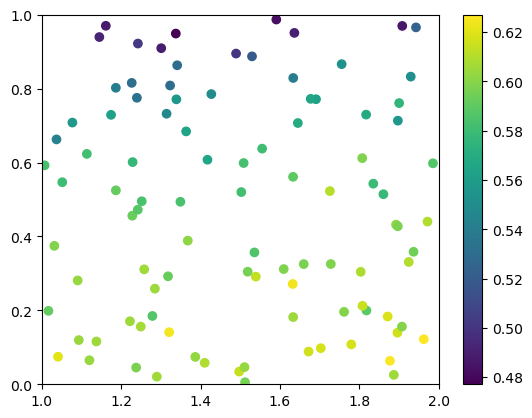

In [15]:
plt.scatter(c1, ce, c=accuracies)
plt.xlim(1, 2)
plt.ylim(0, 1)
plt.colorbar()